# Getting Game Logs for NBA Teams

In [1]:
!pip install nba_api

In [19]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamgamelog
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import time

## Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Get list of NBA teams
nba_teams = teams.get_teams()

## Define the seasons you want (NBA format: 'YYYY-YY')
seasons = ['2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
all_game_logs = []

## Loop through seasons and teams
for season in seasons:
    print(f"\n=== Fetching data for season {season} ===")
    for team in nba_teams:
        team_id = team['id']
        team_name = team['full_name']
        print(f"Fetching games for {team_name} ({season})...")

        try:
            gamelog = teamgamelog.TeamGameLog(
                team_id=team_id,
                season=season,
                season_type_all_star='Regular Season'
            )
            df = gamelog.get_data_frames()[0]
            df['TEAM_NAME'] = team_name
            df['SEASON'] = season  ## Add season column
            all_game_logs.append(df)
        except Exception as e:
            print(f"Failed for {team_name} ({season}): {e}")

        time.sleep(1)  ## Avoid rate limiting

## Combine all logs
games_df = pd.concat(all_game_logs, ignore_index=True)
games_df.to_csv('nba_game_logs_2019_to_2024.csv', index=False)

print("\n✅ Saved as nba_game_logs_2019_to_2024.csv")


=== Fetching data for season 2019-20 ===
Fetching games for Atlanta Hawks (2019-20)...
Fetching games for Boston Celtics (2019-20)...
Fetching games for Cleveland Cavaliers (2019-20)...
Fetching games for New Orleans Pelicans (2019-20)...
Fetching games for Chicago Bulls (2019-20)...
Fetching games for Dallas Mavericks (2019-20)...
Fetching games for Denver Nuggets (2019-20)...
Fetching games for Golden State Warriors (2019-20)...
Fetching games for Houston Rockets (2019-20)...
Fetching games for Los Angeles Clippers (2019-20)...
Fetching games for Los Angeles Lakers (2019-20)...
Fetching games for Miami Heat (2019-20)...
Fetching games for Milwaukee Bucks (2019-20)...
Fetching games for Minnesota Timberwolves (2019-20)...
Fetching games for Brooklyn Nets (2019-20)...
Fetching games for New York Knicks (2019-20)...
Fetching games for Orlando Magic (2019-20)...
Fetching games for Indiana Pacers (2019-20)...
Fetching games for Philadelphia 76ers (2019-20)...
Fetching games for Phoenix S

# Feature Engineering & Dataset Creation

We'll look to see the features included in NBA game log dataset.

In [20]:
df = pd.read_csv('nba_game_logs_2019_to_2024.csv')
print(df.columns)

Index(['Team_ID', 'Game_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'W', 'L', 'W_PCT',
       'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'TEAM_NAME', 'SEASON'],
      dtype='object')


In [21]:
## Load game logs
df = pd.read_csv('nba_game_logs_2019_to_2024.csv')
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values(['TEAM_NAME', 'GAME_DATE'])

## Define base stat list
stat_features = ['PTS', 'REB', 'AST', 'TOV', 'FG_PCT', 'FG3_PCT', 'STL', 'BLK', 'PF', 'FT_PCT']

## 1. Rolling averages (last 5 games)
for feature in stat_features:
    df[f'{feature}_ROLL'] = df.groupby('TEAM_NAME')[feature].transform(
        lambda x: x.shift().rolling(5, min_periods=5).mean()
    )

## 2. Season-to-date averages (cumulative)
for feature in stat_features:
    df[f'{feature}_SEASON'] = df.groupby('TEAM_NAME')[feature].transform(
        lambda x: x.shift().expanding().mean()
    )

## 3. Expanded context features
df['REST_DAYS'] = df.groupby('TEAM_NAME')['GAME_DATE'].diff().dt.days.fillna(1)

def compute_streak(wl_series):
    streaks = []
    streak = 0
    last = None
    for result in wl_series:
        if result == last:
            streak = streak + 1 if result == 'W' else streak - 1
        else:
            streak = 1 if result == 'W' else -1
        streaks.append(streak)
        last = result
    return streaks

df['STREAK'] = df.groupby('TEAM_NAME')['WL'].transform(compute_streak)
df['WINS'] = df.groupby('TEAM_NAME')['WL'].transform(lambda x: x.shift().eq('W').cumsum())
df['LOSSES'] = df.groupby('TEAM_NAME')['WL'].transform(lambda x: x.shift().eq('L').cumsum())
df['WIN_PCT_BEFORE'] = df['WINS'] / (df['WINS'] + df['LOSSES'])

df['MOV'] = df['PTS'] - df.groupby('Game_ID')['PTS'].transform('mean')
df['MOV_ROLL'] = df.groupby('TEAM_NAME')['MOV'].transform(lambda x: x.shift().rolling(5, min_periods=5).mean())

# ===============================
# MATCHUP CREATION
# ===============================

## List of all differential features to compute
roll_diff_features   = [f'{f}_ROLL'   for f in stat_features] + ['MOV_ROLL']
season_diff_features = [f'{f}_SEASON' for f in stat_features]
context_features     = ['REST_DAYS', 'STREAK', 'WIN_PCT_BEFORE']
all_diff_features    = roll_diff_features + season_diff_features + context_features

## Filter out any rows that are missing features
df = df.dropna(subset=all_diff_features)

## Pair up teams by Game_ID
game_id_col = 'Game_ID'
game_pairs = df.groupby(game_id_col).filter(lambda x: len(x) == 2)
team_a = game_pairs.groupby(game_id_col).nth(0).reset_index()
team_b = game_pairs.groupby(game_id_col).nth(1).reset_index()

## Only keep matchups where both teams have full feature data
valid_rows = pd.concat([team_a[all_diff_features], team_b[all_diff_features]], axis=1).dropna().index
team_a = team_a.loc[valid_rows]
team_b = team_b.loc[valid_rows]

## Create matchups DataFrame
matchups = pd.DataFrame()

## Add rolling stat diffs
for feature in roll_diff_features:
    matchups[f'{feature}_DIFF'] = team_a[feature].values - team_b[feature].values

## Add season stat diffs
for feature in season_diff_features:
    matchups[f'{feature}_DIFF'] = team_a[feature].values - team_b[feature].values

## Add context feature diffs
for feature in context_features:
    matchups[f'{feature}_DIFF'] = team_a[feature].values - team_b[feature].values

## Home flag and label
matchups['HOME_FLAG'] = (team_a['MATCHUP'].str.contains('vs')).astype(int)
matchups['LABEL'] = (team_a['WL'] == 'W').astype(int)
matchups['Game_ID'] = team_a['Game_ID']

## Drop any lingering NaNs
matchups = matchups.dropna(subset=['LABEL', 'HOME_FLAG', 'Game_ID']).reset_index(drop=True)

print("Final matchup dataset with rolling + season averages created.")
print("Shape:", matchups.shape)
print(matchups.head())

Final matchup dataset with rolling + season averages created.
Shape: (5737, 27)
   PTS_ROLL_DIFF  REB_ROLL_DIFF  AST_ROLL_DIFF  TOV_ROLL_DIFF  \
0           -4.4           -4.6            4.2            2.4   
1           -2.6           -5.2            4.8            3.0   
2            2.8           -3.2            4.6            0.0   
3            0.6           -1.2            4.0            1.0   
4            5.4           -1.6            5.0            1.4   

   FG_PCT_ROLL_DIFF  FG3_PCT_ROLL_DIFF  STL_ROLL_DIFF  BLK_ROLL_DIFF  \
0           -0.0090            -0.0416           -1.4            0.2   
1            0.0012            -0.0780           -1.8           -0.4   
2           -0.0022            -0.0076           -1.4            0.8   
3           -0.0326            -0.0212            0.6           -0.2   
4           -0.0112             0.0334           -0.8           -1.0   

   PF_ROLL_DIFF  FT_PCT_ROLL_DIFF  ...  STL_SEASON_DIFF  BLK_SEASON_DIFF  \
0          -2.4     

# Building and Training Model

First, we'll prepare the data by splitting it into features (X) and target (y), then normalize the inputs.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Drop non-feature columns
X = matchups.drop(columns=['LABEL', 'Game_ID'])  # Features
y = matchups['LABEL']                            # Target

## Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Normalize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We'll create a baseline model for comparison. If we can't outperform a basic logistic regression model, we'll need to tweak the model and features!

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## Train baseline model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

## Predict and evaluate
y_pred_baseline = logreg.predict(X_test_scaled)
logreg_acc = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Logistic Regression Accuracy: {logreg_acc:.2%}")
print(classification_report(y_test, y_pred_baseline))

Baseline Logistic Regression Accuracy: 76.13%
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       556
           1       0.77      0.77      0.77       592

    accuracy                           0.76      1148
   macro avg       0.76      0.76      0.76      1148
weighted avg       0.76      0.76      0.76      1148



Now, we'll define the Keras model.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Model
input_dim = X_train_scaled.shape[1]

keras_model = Sequential([
    Input(shape=(input_dim,)),

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

keras_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Now, we'll train the model.

In [25]:
history = keras_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

## Store accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## Predict labels and probabilities
y_pred_keras = (keras_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
y_prob_keras = keras_model.predict(X_test_scaled).flatten()

## Accuracy
keras_acc = accuracy_score(y_test, y_pred_keras)
print(f"Keras Test Accuracy: {keras_acc:.2%}")

## Confusion matrix
cm = confusion_matrix(y_test, y_pred_keras)
print("\nConfusion Matrix:")
print(cm)

## Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_keras))

## ROC AUC score
keras_auc = roc_auc_score(y_test, y_prob_keras)
print(f"ROC AUC Score: {keras_auc:.3f}")

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5940 - loss: 0.8358 - val_accuracy: 0.7422 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7011 - loss: 0.6779 - val_accuracy: 0.7456 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7324 - loss: 0.6429 - val_accuracy: 0.7456 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7537 - loss: 0.6174 - val_accuracy: 0.7526 - val_loss: 0.6058 - learning_rate: 0.0010
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.6036 - val_accuracy: 0.7474 - val_loss: 0.6034 - learning_rate: 0.0010
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7681 - loss: 0.5994 - val_accuracy: 0.7526 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7733 - loss: 0.5860 -

In [26]:
## Final evaluation
loss, accuracy = keras_model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.2%}")

## Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (keras_model.predict(X_test_scaled) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7517 - loss: 0.5804
Test Accuracy: 76.31%
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[421 135]
 [137 455]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       556
           1       0.77      0.77      0.77       592

    accuracy                           0.76      1148
   macro avg       0.76      0.76      0.76      1148
weighted avg       0.76      0.76      0.76      1148



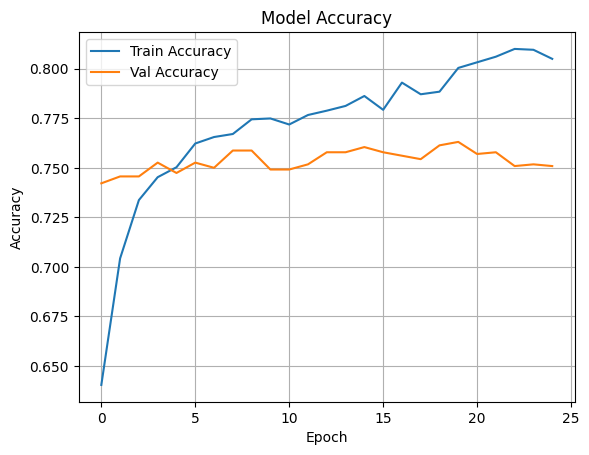

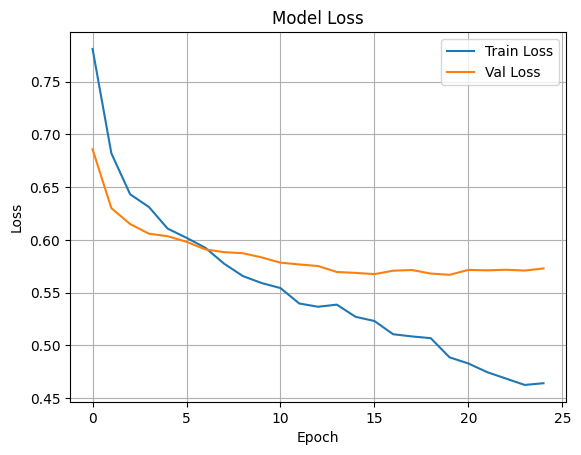

In [27]:
import matplotlib.pyplot as plt

## Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# XG Boost and Feature Importance

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

## Train XGB model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

## Make predictions and store accuracy
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

## Print classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       556
           1       0.77      0.77      0.77       592

    accuracy                           0.76      1148
   macro avg       0.76      0.76      0.76      1148
weighted avg       0.76      0.76      0.76      1148



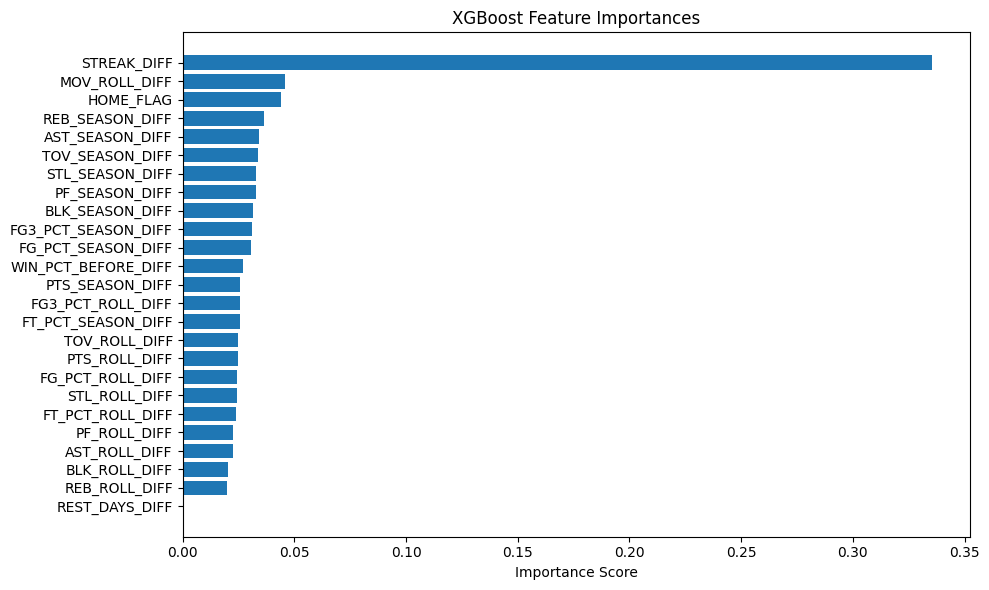

In [29]:
import matplotlib.pyplot as plt
import numpy as np

## Get feature importances from XGBoost
importances = xgb_model.feature_importances_
feature_names = X.columns

## Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_names = feature_names[sorted_idx]

## Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_names, sorted_importances)
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

## Accuracy Comparison

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


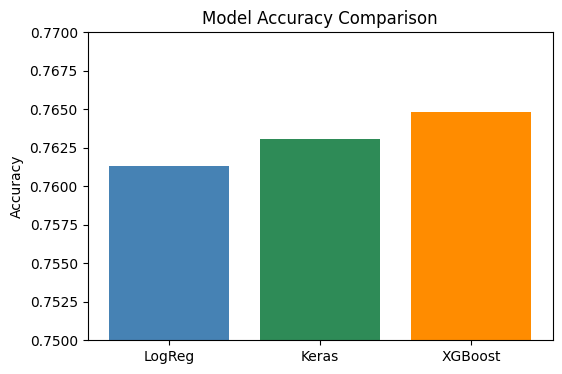

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Get predictions
logreg_acc = accuracy_score(y_test, logreg.predict(X_test_scaled))
keras_acc = accuracy_score(y_test, (keras_model.predict(X_test_scaled) > 0.5).astype(int))
xgb_acc = accuracy_score(y_test, xgb_model.predict(X_test_scaled))

## Plot with custom colors
colors = ['steelblue', 'seagreen', 'darkorange']

plt.figure(figsize=(6, 4))
plt.bar(['LogReg', 'Keras', 'XGBoost'], [logreg_acc, keras_acc, xgb_acc], color=colors)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.75, 0.77)
plt.grid(False)
plt.show()

## ROC Curve

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


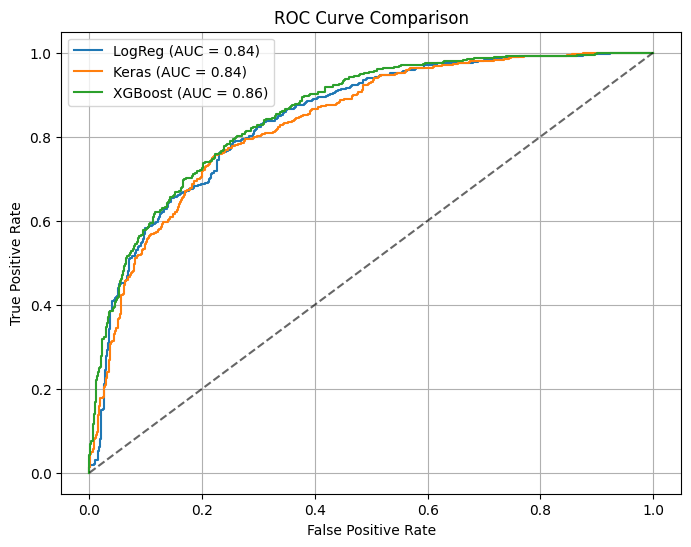

In [41]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

## Logistic Regression
fpr1, tpr1, _ = roc_curve(y_test, logreg.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr1, tpr1, label=f"LogReg (AUC = {auc(fpr1, tpr1):.2f})")

## Keras
keras_probs = keras_model.predict(X_test_scaled).flatten()
fpr2, tpr2, _ = roc_curve(y_test, keras_probs)
plt.plot(fpr2, tpr2, label=f"Keras (AUC = {auc(fpr2, tpr2):.2f})")

## XGBoost
fpr3, tpr3, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr3, tpr3, label=f"XGBoost (AUC = {auc(fpr3, tpr3):.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrices

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


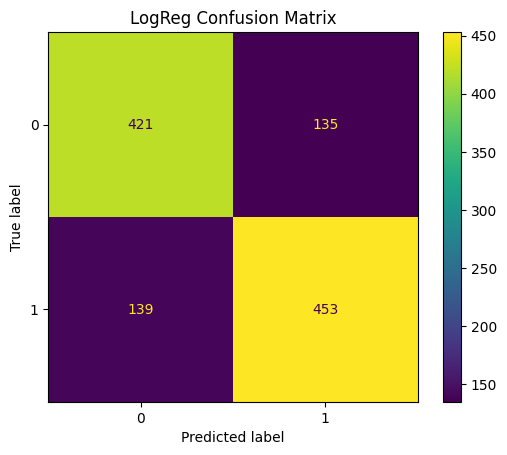

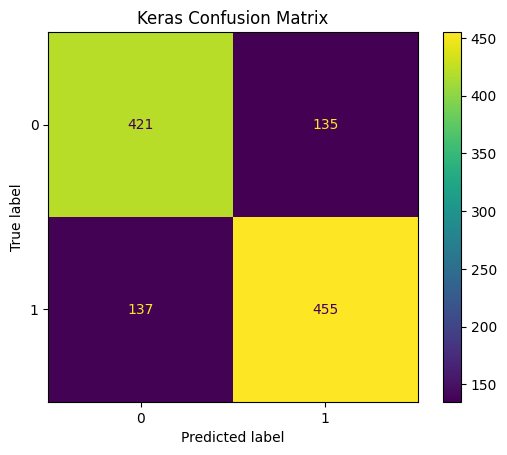

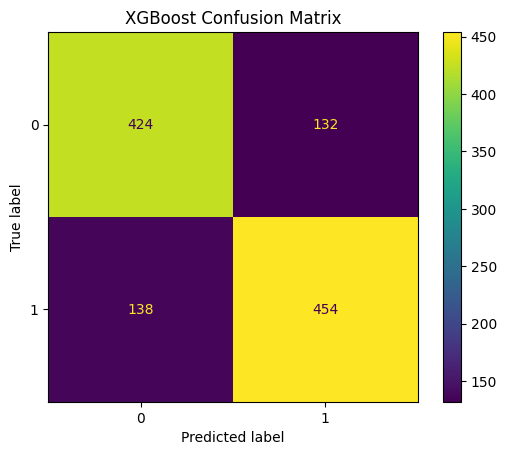

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_preds = {
    'LogReg': logreg.predict(X_test_scaled),
    'Keras': (keras_model.predict(X_test_scaled) > 0.5).astype(int).flatten(),
    'XGBoost': xgb_model.predict(X_test_scaled)
}

for name, preds in model_preds.items():
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.grid(False)
    plt.show()